In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'            
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,CAST(ot.ProvinceUID AS int) AS ProvinceUID  ,pr.Description AS province , CAST(ot.DistrictUID AS INT) AS DistrictUID ,  di.Description AS district 
,CAST( ot.AreaUID AS int) AS AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' 
  AND  ot.AreaUID IS NOT NULL ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO008001532,56,2018-11-07 08:04:43.603,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,244,Myotan 25mg 100's,1.0,677.00,771.75,0.0,0.0,677.00,2018,November,11,7,4,Wednesday,8
1,CSO008001532,56,2018-11-07 08:04:43.603,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,246,Dicloran Gel 50gm,6.0,280.00,319.25,0.0,0.0,1680.00,2018,November,11,7,4,Wednesday,8
2,CSO008001532,56,2018-11-07 08:04:43.603,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,251,Oflo Tabs 200mg 30's,2.0,438.60,500.00,0.0,0.0,877.20,2018,November,11,7,4,Wednesday,8
3,CSO008001532,56,2018-11-07 08:04:43.603,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,253,Panum 40mg Tab 100's,1.0,1660.65,1893.20,0.0,0.0,1660.65,2018,November,11,7,4,Wednesday,8
4,CSO008601228,64,2018-11-07 11:30:40.070,1185,Laksanda Pharmacy,2,Central Province,3,Kandy,211,Peradeniya,86,Sameera Kulathunga,6,J.G.P Marketing (Pvt) Ltd,103,Kids Bunny Tooth Paste 80g,2.0,405.30,462.00,0.0,0.0,810.60,2018,November,11,7,4,Wednesday,11


In [6]:
# select product sales records 
#Belcid Suspension 240ml
# Agent id = 97 (best sales agent) - verify later
#Sec_invoices = invoice_All.loc[(invoice_All['ItemUID'] == 25) & (invoice_All['AgentUID'] == 97)]
Sec_invoices = invoice_All.loc[(invoice_All['ItemUID'] == 25)]

In [7]:
Sec_invoices

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
130,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,30.0,238.7,272.0,0.0,0.0,7161.0,2018,November,11,10,7,Saturday,10
131,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,9.0,9.0,0.0,2018,November,11,10,7,Saturday,10
311,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,6,Eastern Province,7,Ampara,76,Akkaraipattu,77,Mohamed Ramees,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,1000.0,206.1,235.0,0.0,0.0,206100.0,2018,November,11,11,1,Sunday,14
312,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,6,Eastern Province,7,Ampara,76,Akkaraipattu,77,Mohamed Ramees,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,0.0,238.7,272.0,300.0,300.0,0.0,2018,November,11,11,1,Sunday,14
371,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,7,4,Wednesday,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953711,CSO008403806,459,2019-11-26 11:39:50.467,568,Shantha Pharmacy,20,Western Province,23,Gampaha,111,Mirigama,84,Dilshan Wickramasooriya,5,J.B Pharmaceuticals (Pvt)Ltd,25,Belcid Suspension 240ml,0.0,264.0,308.0,2.0,3.0,0.0,2019,November,11,26,3,Tuesday,11
953714,CSO010403826,354,2019-08-29 12:29:16.003,2590,Isuru Pharmacy,16,Southern Province,18,Matara,380,Akuressa,104,Janaka Vidanage,14,Unichemist Distributor,25,Belcid Suspension 240ml,10.0,263.2,300.0,0.0,0.0,2632.0,2019,August,8,29,5,Thursday,12
953715,CSO010403826,354,2019-08-29 12:29:16.003,2590,Isuru Pharmacy,16,Southern Province,18,Matara,380,Akuressa,104,Janaka Vidanage,14,Unichemist Distributor,25,Belcid Suspension 240ml,0.0,263.2,300.0,3.0,3.0,0.0,2019,August,8,29,5,Thursday,12
953717,CSO010403877,354,2019-09-01 12:44:21.617,2732,New Chandana Pharmacy,16,Southern Province,19,Hambantota,383,Beliatta,104,Janaka Vidanage,14,Unichemist Distributor,25,Belcid Suspension 240ml,10.0,263.2,300.0,0.0,0.0,2632.0,2019,September,9,1,1,Sunday,12


In [8]:
Sec_invoices.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
130,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,30.0,238.7,272.0,0.0,0.0,7161.0,2018,November,11,10,7,Saturday,10
131,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,9.0,9.0,0.0,2018,November,11,10,7,Saturday,10
311,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,6,Eastern Province,7,Ampara,76,Akkaraipattu,77,Mohamed Ramees,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,1000.0,206.1,235.0,0.0,0.0,206100.0,2018,November,11,11,1,Sunday,14
312,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,6,Eastern Province,7,Ampara,76,Akkaraipattu,77,Mohamed Ramees,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,0.0,238.7,272.0,300.0,300.0,0.0,2018,November,11,11,1,Sunday,14
371,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,7,4,Wednesday,8


In [9]:
#group data by invoice
Sec_invoices_Agg = Sec_invoices.groupby("ID").agg({'GrossValue':'sum' , 'MonthName' : 'max'}).reset_index()

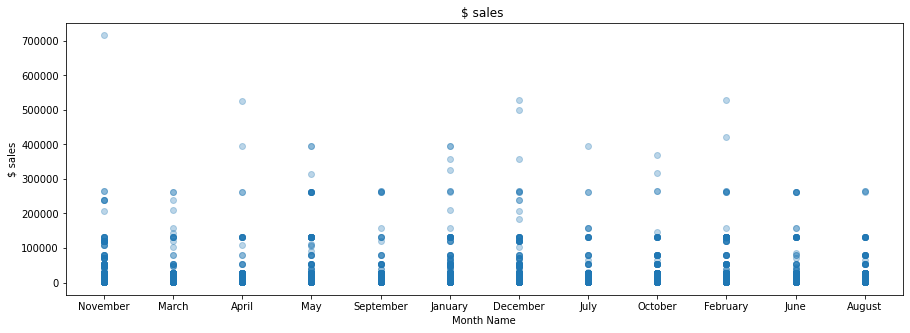

In [11]:
plt.scatter(Sec_invoices_Agg.MonthName , Sec_invoices_Agg.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Month Name")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [12]:
# remove z score > 3 
Selc_Inv_Nor = Sec_invoices_Agg[(np.abs(stats.zscore(Sec_invoices_Agg["GrossValue"])) < 3)]

In [13]:
Selc_Inv_Nor.head()

,ID,GrossValue,MonthName
0,BO0092000094,2387.0,November
1,BO0092000098,11935.0,November
2,BO0092000099,2387.0,November
3,BO0092000100,7161.0,November
4,BO0092000101,2387.0,November


In [14]:
Sected_invoices_Nor = Sec_invoices[Sec_invoices['ID'].isin(Selc_Inv_Nor.ID)]

In [15]:
Sected_invoices_Nor.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
130,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,30.0,238.7,272.0,0.0,0.0,7161.0,2018,November,11,10,7,Saturday,10
131,CSO009400376,107,2018-11-10 10:36:01.357,691,Waruna Pharmacy,20,Western Province,21,Colombo,136,Delkanda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,9.0,9.0,0.0,2018,November,11,10,7,Saturday,10
371,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,7,4,Wednesday,8
372,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24,North Western Province,26,Puttalam,92,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,0.0,238.7,272.0,3.0,3.0,0.0,2018,November,11,7,4,Wednesday,8
470,CSO009400371,107,2018-11-10 10:41:16.243,972,Pelawatta Pharmacy,20,Western Province,21,Colombo,175,Palawatta,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,10,7,Saturday,10


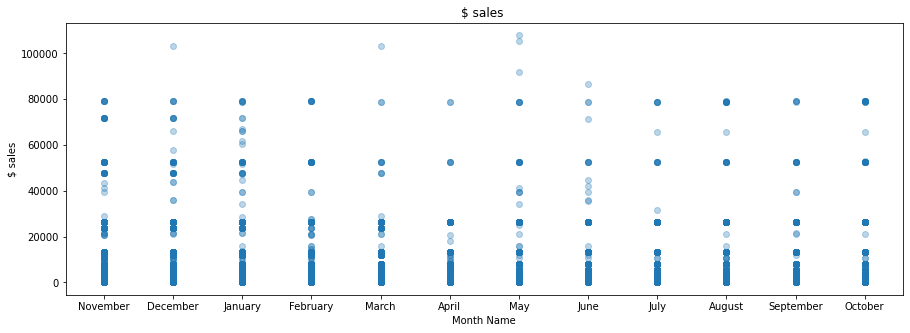

In [16]:
plt.scatter(Sected_invoices_Nor.MonthName , Sected_invoices_Nor.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Month Name")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [17]:
#group data by invoice:
Sec_invoices_grp = Sec_invoices.groupby("ID").agg({'OutletUID' :'max', 'DistributorUID':'max','UnitQty':'sum', 'UnitPrice':'max'
                                                   ,'FreeQty':'sum', 'FreeCompanyQty':'sum' ,'Year': 'max' 
                                                   ,'ProvinceUID': 'max' ,'DistrictUID': 'max' , 'AreaUID':'max' 
                                                   ,'GrossValue':'sum' , 'Month' : 'max'}).reset_index()

In [18]:
Sec_invoices_grp.head()

,ID,OutletUID,DistributorUID,UnitQty,UnitPrice,FreeQty,FreeCompanyQty,Year,ProvinceUID,DistrictUID,AreaUID,GrossValue,Month
0,BO0092000094,1645,8,10.0,238.7,3.0,3.0,2018,20,22,259,2387.0,11
1,BO0092000098,1698,8,50.0,238.7,15.0,15.0,2018,16,17,260,11935.0,11
2,BO0092000099,1703,8,10.0,238.7,3.0,3.0,2018,16,17,260,2387.0,11
3,BO0092000100,1675,8,30.0,238.7,9.0,9.0,2018,16,17,263,7161.0,11
4,BO0092000101,3274,8,10.0,238.7,3.0,3.0,2018,16,17,277,2387.0,11


In [19]:
Sec_invoices_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10115 entries, 0 to 10114
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10115 non-null  object 
 1   OutletUID       10115 non-null  int64  
 2   DistributorUID  10115 non-null  int64  
 3   UnitQty         10115 non-null  float64
 4   UnitPrice       10115 non-null  float64
 5   FreeQty         10115 non-null  float64
 6   FreeCompanyQty  10115 non-null  float64
 7   Year            10115 non-null  object 
 8   ProvinceUID     10115 non-null  int64  
 9   DistrictUID     10115 non-null  int64  
 10  AreaUID         10115 non-null  int64  
 11  GrossValue      10115 non-null  float64
 12  Month           10115 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 1.0+ MB


In [20]:
Sec_invoices_grp['Year'] = Sec_invoices_grp['Year'].astype(str).astype(int)

In [21]:
Sec_invoices_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10115 entries, 0 to 10114
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10115 non-null  object 
 1   OutletUID       10115 non-null  int64  
 2   DistributorUID  10115 non-null  int64  
 3   UnitQty         10115 non-null  float64
 4   UnitPrice       10115 non-null  float64
 5   FreeQty         10115 non-null  float64
 6   FreeCompanyQty  10115 non-null  float64
 7   Year            10115 non-null  int32  
 8   ProvinceUID     10115 non-null  int64  
 9   DistrictUID     10115 non-null  int64  
 10  AreaUID         10115 non-null  int64  
 11  GrossValue      10115 non-null  float64
 12  Month           10115 non-null  int64  
dtypes: float64(5), int32(1), int64(6), object(1)
memory usage: 987.9+ KB


In [22]:
X = Sec_invoices_grp[["OutletUID","ProvinceUID","DistrictUID", "AreaUID" ,"DistributorUID","UnitPrice","Year","Month"]]
#X = Sec_invoices_grp[["OutletUID" ,"DistributorUID","UnitPrice","Year","Month"]]
y = Sec_invoices_grp[["GrossValue"]]

In [23]:
X.head()

,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month
0,1645,20,22,259,8,238.7,2018,11
1,1698,16,17,260,8,238.7,2018,11
2,1703,16,17,260,8,238.7,2018,11
3,1675,16,17,263,8,238.7,2018,11
4,3274,16,17,277,8,238.7,2018,11


In [24]:
y.head()

,GrossValue
0,2387.0
1,11935.0
2,2387.0
3,7161.0
4,2387.0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [26]:
print(X.shape, X_train.shape, X_test.shape)

(10115, 8) (8092, 8) (2023, 8)


Linear Regression

In [27]:
regressor = LinearRegression()

In [28]:
regressor.fit(X_train, y_train)

LinearRegression()

In [29]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [30]:
# R squared Value
r2_train = metrics.r2_score(y_train, training_data_prediction)

In [31]:
print('R Squared value = ', r2_train)

R Squared value =  0.01608711289394993


In [32]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [33]:
# R squared Value
r2_test = metrics.r2_score(y_test, test_data_prediction)

In [34]:
print('R Squared value = ', r2_test)

R Squared value =  0.007398363301269195


### Since R Squared is 0.99 the 99% of test data is considered to be predicted correctly. 

In [35]:
y_test

,GrossValue
6874,2640.0
3938,1320.0
2589,13160.0
8353,13160.0
4850,1584.0
...,...
2125,5264.0
4367,7896.0
5677,2387.0
6806,2640.0


In [36]:
test_data_prediction

array([[10768.6569307 ],
       [ 8536.38462002],
       [13775.97983637],
       ...,
       [11089.82323685],
       [13888.129886  ],
       [ 7232.18414935]])

In [37]:
# get data to DF
Final_Result = X_test
Final_Result["GrossValue"] = y_test
Prd_Results = pd.DataFrame(data = test_data_prediction, columns = ['GrossValuePrd'], index = X_test.index.copy())
Final_Result = pd.merge(Final_Result, Prd_Results, how = 'left', left_index = True, right_index = True)

In [38]:
Final_Result

,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
6874,2547,16,18,389,14,264.0,2020,1,2640.0,10768.656931
3938,1576,20,22,275,8,264.0,2020,1,1320.0,8536.384620
2589,1412,6,9,248,7,263.2,2019,3,13160.0,13775.979836
8353,3027,20,23,487,12,263.2,2019,5,13160.0,11352.429361
4850,708,20,21,184,9,264.0,2019,12,1584.0,10163.954740
...,...,...,...,...,...,...,...,...,...,...
2125,1212,2,3,200,6,263.2,2019,8,5264.0,18501.210755
4367,787,20,21,135,9,263.2,2019,4,7896.0,12757.180165
5677,2502,30,31,371,13,238.7,2018,11,2387.0,11089.823237
6806,4022,16,18,396,14,264.0,2019,12,2640.0,13888.129886


In [39]:
Final_Result = Final_Result.sort_index()
Final_Result = Final_Result.reset_index()

In [40]:
Final_Result.head()

,index,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
0,3,1675,16,17,263,8,238.7,2018,11,7161.0,14612.379725
1,10,2276,20,22,52,24,238.7,2019,3,2387.0,6003.964495
2,20,2143,20,21,340,24,238.7,2019,4,11935.0,9461.251883
3,30,2250,20,21,60,24,263.2,2019,5,2632.0,11775.096712
4,32,2143,20,21,340,24,263.2,2019,5,7896.0,12808.869552


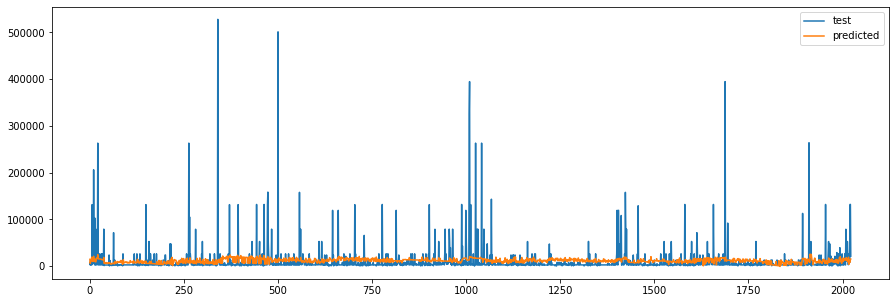

In [41]:
plt.plot(Final_Result.GrossValue)
plt.plot(Final_Result.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [42]:
# remove z score > 3
Final_Result_No_Out = Final_Result[(np.abs(stats.zscore(Final_Result["GrossValue"])) < 3)]

In [43]:
Final_Result_No_Out

,index,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
0,3,1675,16,17,263,8,238.7,2018,11,7161.0,14612.379725
1,10,2276,20,22,52,24,238.7,2019,3,2387.0,6003.964495
2,20,2143,20,21,340,24,238.7,2019,4,11935.0,9461.251883
3,30,2250,20,21,60,24,263.2,2019,5,2632.0,11775.096712
4,32,2143,20,21,340,24,263.2,2019,5,7896.0,12808.869552
...,...,...,...,...,...,...,...,...,...,...,...
2016,10086,4995,10,11,439,25,264.0,2019,10,3168.0,19060.841677
2017,10094,2859,10,15,454,25,264.0,2019,12,26400.0,3952.409235
2018,10095,2893,10,12,423,25,264.0,2019,12,26400.0,12212.795888
2019,10099,2773,10,11,425,25,264.0,2020,1,7920.0,14038.772062


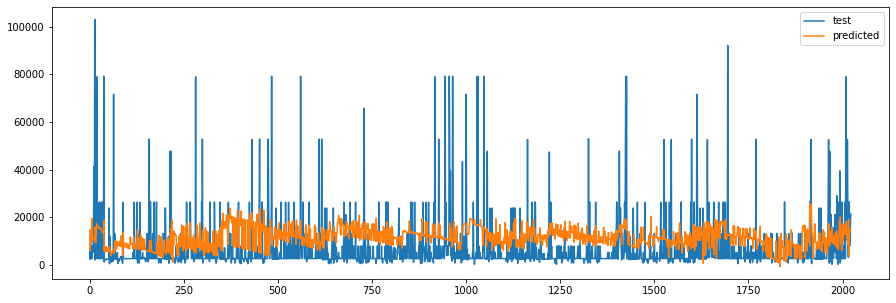

In [44]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [45]:
# GrossValue and GrossValuePrd less than 100,000
Final_Result_No_Out = Final_Result.loc[(Final_Result['GrossValue'] < 100000) & (Final_Result['GrossValuePrd']  < 100000)]

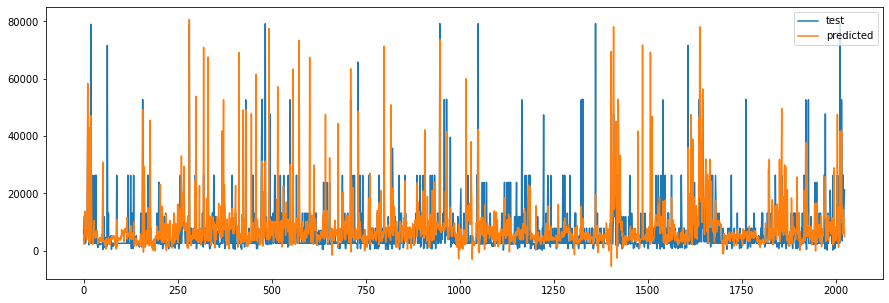

In [59]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [46]:
# GrossValue and GrossValuePrd less than 40,000
Final_Result_No_Out = Final_Result.loc[(Final_Result['GrossValue'] < 40000) & (Final_Result['GrossValuePrd']  < 40000)]

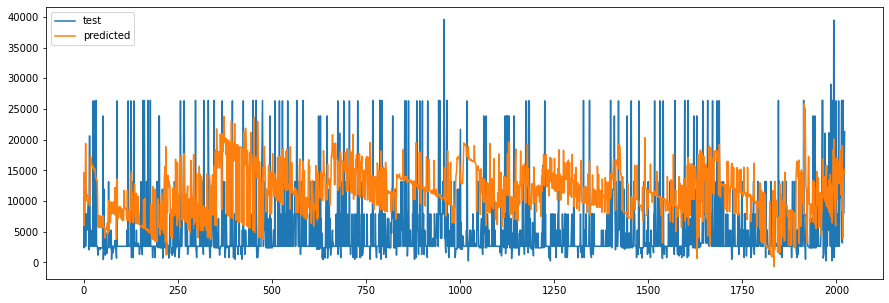

In [47]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])